In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(lme4)
library(lmerTest)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [4]:
import matplotlib
font = {
    'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 12
}

matplotlib.rc('font', **font)

In [5]:
def save_paper_input(input_name, input_str):
    filename = f"./inputs/{input_name}.tex"
    with open(filename, 'w') as file:
        file.write(input_str)
    print(f"Saved to {filename}:\n{input_str}")
    
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

In [6]:
import json
from matplotlib import pyplot as plt

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns

from data_analysis import download_data, download_condition_counts, calc_condition_counts, ExperimentDataLoader
from itertools import product
from frozendict import frozendict
from tqdm.notebook import tqdm
from functools import lru_cache
from construal_shifting.task_modeling.participant_model import ParticipantModel
from construal_shifting.task_modeling.construal_trial_model import ConstrualTrialModel

exp_data = ExperimentDataLoader(
    trialdata_file="rawtrialdata-anon.csv"
)
pmod_stats = pd.read_pickle('./data/participantmodel_stats.pkl')
pmod_stats['initial_rt_log_milliseconds'] = np.log(pmod_stats['initial_rt_milliseconds'])
pmod_stats['trial_type'] = pmod_stats['grid_name'].apply(lambda x: x.split('-')[-1])

# Analysis with fit model

In [8]:
model_fit_df = pd.read_pickle('./data/model_fits.pkl')
model_fit_df['df'] = model_fit_df[[
    'fit_construal_cost_weight', 'fit_construal_set_stickiness', 'fit_action_random_choice'
]].apply(lambda r: sum([t == True for t in r]), axis=1)
model_fit_df['AIC'] = model_fit_df.apply(lambda r: 2*r['df'] + r['NLL'], axis=1)
model_fit_df['dAIC'] = model_fit_df['AIC'] - model_fit_df['AIC'].min()

In [9]:
model_fits = model_fit_df.copy()
model_fits['Model'] = [
    "No complexity or switch cost",
    "Only switch cost",
    "Only complexity cost",
    "Both complexity and switch cost"
]
model_fits = model_fits[['Model', 'construal_cost_weight', 'construal_set_stickiness', 'action_random_choice', 'df', 'AIC', 'dAIC']]
model_fits = model_fits.sort_values(by="dAIC", ascending=False)
model_fits = model_fits.round(dict(
    action_random_choice=2, 
    construal_cost_weight=2,
    construal_set_stickiness=2,
))
model_fits['AIC'] = model_fits['AIC'].astype(int)
model_fits['dAIC'] = model_fits['dAIC'].astype(int)
model_fits = model_fits.rename(columns=dict(
    action_random_choice=r'$\varepsilon$', 
    construal_cost_weight=r'$\lambda_{\text{Complexity}}$',
    construal_set_stickiness=r'$\lambda_{\text{Switch}}$',
    AIC="AIC",
    dAIC=r"$\Delta$AIC"
))
model_fits_table = model_fits.to_latex(
    # na_rep="---", 
    escape=False,
    column_format="lrrrrrr",
    # col_space=1,
    index=False
)
# model_fits
print(model_fits_table)

\begin{tabular}{lrrrrrr}
\toprule
                          Model &  $\lambda_{\text{Complexity}}$ &  $\lambda_{\text{Switch}}$ &  $\varepsilon$ &  df &    AIC &  $\Delta$AIC \\
\midrule
   No complexity or switch cost &                           0.00 &                       0.00 &            0.1 &   1 & 132094 &         2804 \\
           Only complexity cost &                           5.42 &                       0.00 &            0.1 &   2 & 130535 &         1245 \\
               Only switch cost &                           0.00 &                       8.54 &            0.1 &   2 & 130057 &          767 \\
Both complexity and switch cost &                           1.69 &                       5.33 &            0.1 &   3 & 129289 &            0 \\
\bottomrule
\end{tabular}



In [10]:
model_fits = model_fit_df.copy()
model_fits['Model'] = [
    "No complexity or switch cost",
    "Only switch cost",
    "Only complexity cost",
    "Both complexity and switch cost"
]
model_fits = model_fits[['Model', 'construal_cost_weight', 'construal_set_stickiness', 'action_random_choice', 'df', 'AIC', 'dAIC']]
model_fits = model_fits.sort_values(by="dAIC", ascending=False)
model_fits.round(2)

,Model,construal_cost_weight,construal_set_stickiness,action_random_choice,df,AIC,dAIC
0,No complexity or switch cost,0.00,0.00,0.1,1,132094.38,2804.43
2,Only complexity cost,5.42,0.00,0.1,2,130535.47,1245.52
1,Only switch cost,0.00,8.54,0.1,2,130057.91,767.97
3,Both complexity and switch cost,1.69,5.33,0.1,3,129289.94,0.00


## Analysis of RTs with model

In [11]:
def bootstrap_ci(
    x,
    n_resamplings = 10000,
    ci = .95,
):
    samples = np.random.choice(x, size=(n_resamplings, len(x)))
    sample_stat = [np.mean(samp) for samp in samples]
    sample_stat = sorted(sample_stat)
    lower_bound = sample_stat[int(n_resamplings*((1-ci)/2))]
    upper_bound = sample_stat[int(n_resamplings*(ci+(1-ci)/2))]
    real_mean = np.mean(x)
    return real_mean - lower_bound, upper_bound - real_mean

In [12]:
test_trial_stats = pmod_stats[pmod_stats['trial'] >= 12]

In [13]:
test_trials = pd.read_json('./data/test_trial_stats.json')
pmod_stats_test_trials = pmod_stats[pmod_stats['grid_name'].apply(lambda n: 'test' in n)].reset_index(drop=True)
pmod_stats_training_trials = pmod_stats[pmod_stats['grid_name'].apply(lambda n: 'test' not in n)].reset_index(drop=True)
pmod_stats_test_trials['test_trial_num'] = pmod_stats_test_trials['trial'] - 12
pmod_stats_test_trials = pmod_stats_test_trials.merge(
    test_trials[['sessionId', 'test_trial_num', 'visited_critical_notch']],
    on=['sessionId', 'test_trial_num']
)

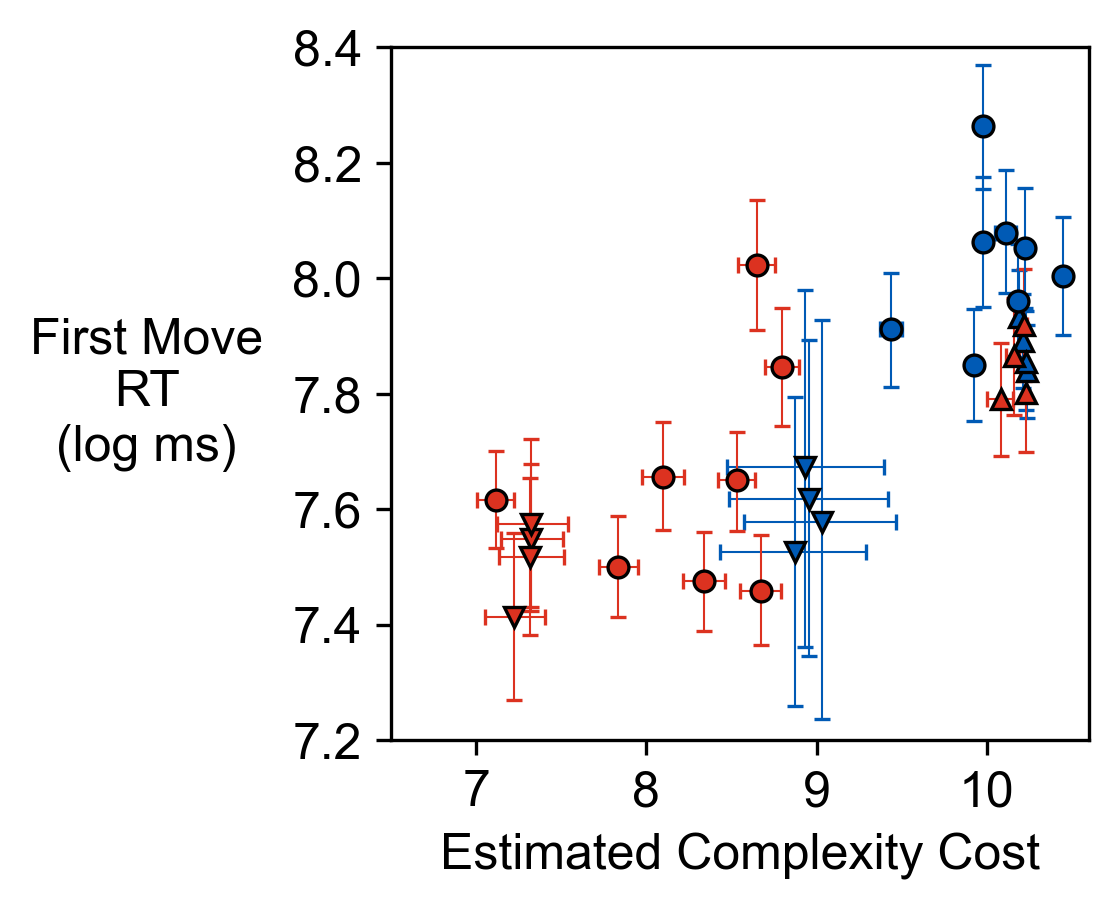

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)
test_means = pmod_stats_test_trials.groupby(['grid_name', 'condition_name', 'visited_critical_notch'])[[
    'initial_rt_log_milliseconds',
    'expected_cognitive_cost',
]].mean().reset_index()
test_err = pmod_stats_test_trials.groupby(['grid_name', 'condition_name', 'visited_critical_notch'])[[
    'initial_rt_log_milliseconds',
    'expected_cognitive_cost',
]].agg(bootstrap_ci).reset_index()
train_means = pmod_stats_training_trials.groupby(['grid_name', 'condition_name'])[[
    'initial_rt_log_milliseconds',
    'expected_cognitive_cost',
]].mean().reset_index()
train_err = pmod_stats_training_trials.groupby(['grid_name', 'condition_name'])[[
    'initial_rt_log_milliseconds',
    'expected_cognitive_cost',
]].agg(bootstrap_ci).reset_index()

shared_plot_params = dict(
    markersize=5,
    lw=0,
    markeredgecolor="k",
    markeredgewidth=.8,
)

for visited_critical_notch, condition_name in product(
    [True, False], ['ffffffffffff', 'cccccccccccc']
):
    selector_means = \
        (test_means['visited_critical_notch'] == visited_critical_notch) & \
        (test_means['condition_name'] == condition_name)
    
    selector_err = \
        (test_err['visited_critical_notch'] == visited_critical_notch) & \
        (test_err['condition_name'] == condition_name)
    ax.errorbar(
        x=test_means[selector_means]['expected_cognitive_cost'],
        y=test_means[selector_means]['initial_rt_log_milliseconds'],
        xerr=np.array(list(test_err[selector_err]['expected_cognitive_cost'])).T,
        yerr=np.array(list(test_err[selector_err]['initial_rt_log_milliseconds'])).T,
        marker={True: '^', False: 'v'}[visited_critical_notch],
        color={"ffffffffffff": "#005AB5", "cccccccccccc": "#DC3220"}[condition_name],
        elinewidth=.5,
        capsize=2,
        capthick=.4,
        **shared_plot_params
    )

ax.errorbar(
    x=train_means[train_means['condition_name'] == 'c'*12]['expected_cognitive_cost'],
    y=train_means[train_means['condition_name'] == 'c'*12]['initial_rt_log_milliseconds'],
    xerr=np.array(list(train_err[train_err['condition_name'] == 'c'*12]['expected_cognitive_cost'])).T,
    yerr=np.array(list(train_err[train_err['condition_name'] == 'c'*12]['initial_rt_log_milliseconds'])).T,
    marker='o',
    color="#DC3220",
    elinewidth=.5,
    capsize=2,
    capthick=.5,
    **shared_plot_params,
    # markerfacecolor='none',
)
ax.errorbar(
    x=train_means[train_means['condition_name'] == 'f'*12]['expected_cognitive_cost'],
    y=train_means[train_means['condition_name'] == 'f'*12]['initial_rt_log_milliseconds'],
    xerr=np.array(list(train_err[train_err['condition_name'] == 'f'*12]['expected_cognitive_cost'])).T,
    yerr=np.array(list(train_err[train_err['condition_name'] == 'f'*12]['initial_rt_log_milliseconds'])).T,
    marker='o',
    color="#005AB5",
    elinewidth=.5,
    capsize=2,
    capthick=.5,
    **shared_plot_params,
    # markerfacecolor='none',
)
ax.set_ylabel(
    "First Move\nRT\n(log ms)",
    rotation="horizontal",
    labelpad=35,
    va='center'
)
ax.set_xlabel("Estimated Complexity Cost")
ax.set_ylim(7.2, 8.4)
ax.set_yticks([7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4])
ax.set_xlim(6.5, 10.6)
ax.set_xticks([7, 8, 9, 10])
# plt.savefig('./figures/exp1_init_rt_comp_cost.pdf', bbox_inches = "tight")

In [15]:
%%R -i pmod_stats -o model_comparison,cost_mod_coeff
base_mod <- lmer(
    initial_rt_log_milliseconds ~ (1 | sessionId),
    data=pmod_stats,
    REML=F
)
trial_mod <- update(base_mod, . ~ . + trial, REML=F)
cost_mod <- update(base_mod, . ~ . + trial + expected_cognitive_cost, REML=F)
model_comparison <- anova(
    base_mod,
    trial_mod,
    cost_mod,
    test="LRT"
)
cost_mod_coeff <- summary(cost_mod)$coeff
summary(cost_mod)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: 
initial_rt_log_milliseconds ~ (1 | sessionId) + trial + expected_cognitive_cost
   Data: pmod_stats

     AIC      BIC   logLik deviance df.resid 
 12621.2  12656.1  -6305.6  12611.2     7956 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.8192 -0.6103 -0.0239  0.5936  4.6374 

Random effects:
 Groups    Name        Variance Std.Dev.
 sessionId (Intercept) 0.4837   0.6955  
 Residual              0.2350   0.4848  
Number of obs: 7961, groups:  sessionId, 419

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)              7.299e+00  6.799e-02  3.867e+03 107.363  < 2e-16 ***
trial                   -6.881e-03  9.999e-04  7.550e+03  -6.881  6.4e-12 ***
expected_cognitive_cost  6.478e-02  6.378e-03  7.917e+03  10.156  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation 

In [16]:
cost_mod_coeff_df = pd.DataFrame(
    data=cost_mod_coeff,
    index=["Intercept", "trial", "expected_cognitive_cost"],
    columns=["Estimate", "Std. Error", "df", "t value", "Pr(>|t|)"]
)

In [17]:
model_comparison['summary'] = model_comparison.apply(
    lambda r: f"$\chi^{2}({r['Chi Df']:.0f}) = {r['Chisq']:.2f}, p = {latex_float(r['Pr(>Chisq)']*3)}$",
    axis=1
)
model_comparison['model'] = model_comparison.index
for _, row in model_comparison.iterrows():
    if 'base' in row['model']:
        continue
    save_paper_input(f"exp1_{row['model']}_RT_cost_pred_chisq_test", row['summary'])

Saved to ./inputs/exp1_trial_mod_RT_cost_pred_chisq_test.tex:
$\chi^2(1) = 31.48, p = 6.1 \times 10^{-8}$
Saved to ./inputs/exp1_cost_mod_RT_cost_pred_chisq_test.tex:
$\chi^2(1) = 102.37, p = 1.4 \times 10^{-23}$


/Users/markho/Dropbox/Cog-Sci-Research/Projects-active/construal-shifting-public/env37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [18]:
cost_mod_coeff_df

,Estimate,Std. Error,df,t value,Pr(>|t|)
Intercept,7.299335,0.067987,3866.842335,107.363015,0.000000e+00
trial,-0.006881,0.001000,7549.995044,-6.881478,6.397879e-12
expected_cognitive_cost,0.064777,0.006378,7917.490861,10.155825,4.383295e-24


In [19]:
cost_mod_coeff_df['summary'] = cost_mod_coeff_df.apply(
    lambda r: f"$\\beta = {r['Estimate']:.3f}$, S.E. $= {r['Std. Error']:.3f}$",
    axis=1
)
cost_mod_coeff_df['summary']
for idx, row in cost_mod_coeff_df.iterrows():
    save_paper_input(f"exp1_{idx}_RT_cost_pred_reg_est", row['summary'])

Saved to ./inputs/exp1_Intercept_RT_cost_pred_reg_est.tex:
$\beta = 7.299$, S.E. $= 0.068$
Saved to ./inputs/exp1_trial_RT_cost_pred_reg_est.tex:
$\beta = -0.007$, S.E. $= 0.001$
Saved to ./inputs/exp1_expected_cognitive_cost_RT_cost_pred_reg_est.tex:
$\beta = 0.065$, S.E. $= 0.006$
